In [4]:
# Qiskit module
from qiskit import QuantumCircuit, transpile
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np
from osp.graph_state import GraphStateDense, GraphState
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [5]:
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

ibmqfactory.load_account:WARNING:2021-04-16 19:10:00,560: Credentials are already in use. The existing account in the session will be replaced.


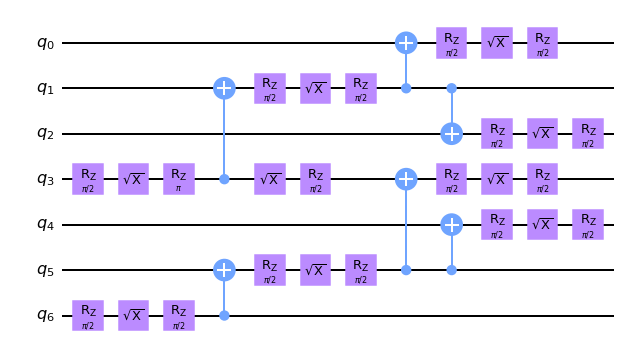

In [9]:
state_circuit = GraphStateDense(backend)
state_circuit.draw(output='mpl')

In [4]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        # Why only {-1, 0, 1} are possible values?
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.

    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.

    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ


In [5]:
#generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
#print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

In [6]:
## Append the stabilizer measurements to the graph state circuit
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

In [7]:
num_qubits = 7
labels = ['0000000',
          '0000011',
          '0000101', '0000110', # Added
          '0001001', '0001010', '0001100',
          '0010001', '0010010', '0010100', '0011000',
          '0100001', '0100010', '0100100', '0101000', '0110000',
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000',
          '1111111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)


In [8]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

In [9]:
# backend is already ibmq_casablanca, do not replace it
#backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))
backend = provider.get_backend('ibmq_casablanca')


In [10]:
reps = 16


In [11]:
all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]

    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)


Job IDs (1/16): 
 measurement calibration: 605a10d6ef04bb8e9b5f9014
 stabilizer measurements: 605a10cf49334346b2386b69
Job IDs (2/16): 
 measurement calibration: 605a10dcef04bb81615f9015
 stabilizer measurements: 605a10da49334372de386b6a
Job IDs (3/16): 
 measurement calibration: 605a10e211fac493ce942b43
 stabilizer measurements: 605a10e0ef04bb34595f9016
Job IDs (4/16): 
 measurement calibration: 605a10e8ef04bb0a445f9017
 stabilizer measurements: 605a10e66e52961928821025
Job IDs (5/16): 
 measurement calibration: 605a10ed11fac480e6942b45
 stabilizer measurements: 605a10ec11fac463e3942b44
Job IDs (6/16): 
 measurement calibration: 605a10f596b215767e806f8a
 stabilizer measurements: 605a10f26b0b89aeefada3e9
Job IDs (7/16): 
 measurement calibration: 605a10fb11fac4a3b7942b47
 stabilizer measurements: 605a10f9493343556d386b6e
Job IDs (8/16): 
 measurement calibration: 605a1101ef04bb786f5f9019
 stabilizer measurements: 605a10ff6b0b894aaaada3eb
Job IDs (9/16): 
 measurement calibration: 605a1

In [ ]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass


In [11]:
job_ids = ['605a10cf49334346b2386b69',
           '605a10da49334372de386b6a',
           '605a10e0ef04bb34595f9016',
           '605a10e66e52961928821025',
           '605a10ec11fac463e3942b44',
           '605a10f26b0b89aeefada3e9',
           '605a10f9493343556d386b6e',
           '605a10ff6b0b894aaaada3eb',
           '605a11056b0b897f81ada3ed',
           '605a110ca0998e382b3fc399',
           '605a1112fe6a8e4036b0ee50',
           '605a11196b0b89bd40ada3ef',
           '605a1120fe6a8e86c6b0ee52',
           '605a1126fe6a8e0faab0ee53',
           '605a112da0998e76673fc39b',
           '605a11332b8d41b108651acc']
job_mit_ids = ['605a10d6ef04bb8e9b5f9014',
               '605a10dcef04bb81615f9015',
               '605a10e211fac493ce942b43',
               '605a10e8ef04bb0a445f9017',
               '605a10ed11fac480e6942b45',
               '605a10f596b215767e806f8a',
               '605a10fb11fac4a3b7942b47',
               '605a1101ef04bb786f5f9019',
               '605a110749334308b3386b6f',
               '605a110efe6a8e2269b0ee4f',
               '605a11142b8d414d0c651acb',
               '605a111bfe6a8e3219b0ee51',
               '605a112296b215da1e806f8d',
               '605a11286e5296374682102b',
               '605a112ffe6a8e00f1b0ee54',
               '605a1135a0998ec6423fc39d']

result_backend = []
result_mit_backend = []
for job_id in job_ids:
    # Retrieve results (this may take a while depending on the queue)
    #result_backend.append(job.result())
    result_backend.append(backend.retrieve_job(job_id).result())
for job_mit_id in job_mit_ids:
    result_mit_backend.append(backend.retrieve_job(job_mit_id).result())



In [12]:

def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.

    Args:
        stabilizer (str): a stabilizer string

    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag

def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev


In [13]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)


In [14]:
## Mitigate the stabilizer expectation values
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)

    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)

    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])




In [15]:
print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))


Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.689 ± 0.021

CTMP error mitigation
F(ibmq_casablanca) = 0.838 ± 0.024
